# Bibliotecas

In [96]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Métricas de Erro

In [97]:
# Root Mean Square Error
def rmse_metric(img1, img2):
    return np.sqrt(np.mean((img1.astype("float") - img2.astype("float")) ** 2))

# Coleta das Imagens de Teste

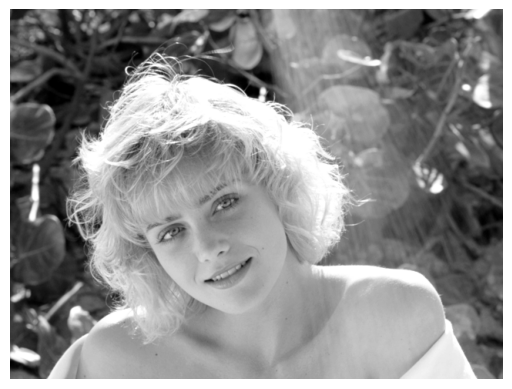

In [98]:
# Carregar a imagem em modo grayscale
imagem = cv2.imread('images\pgm\marcie.ascii.pgm', cv2.IMREAD_GRAYSCALE)

# Exibindo imagem
plt.imshow(imagem, cmap='gray')
plt.axis('off') 
plt.show()

In [99]:
# Shape da Imagem
imagem.shape

(480, 640)

# Implementação JPEG 

## DCT

In [100]:
# Função que realiza a transformada DCT
def dct_transform(img, step=8):

    size = img.shape                    # Shape da imagem
    DCT = np.zeros(size, dtype=float)   # Cria uma matriz para armazenar os coeficientes DCT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            dct = cv2.dct(img[y:y+step, x:x+step])   # Aplica DCT no bloco 8x8

            DCT[y:y+step, x:x+step] = dct     # Salva o bloco DCT

    return DCT

# Função que realiza a inversa da DCT (IDCT)
def idct_transform(dct_coefs, step=8):

    size = dct_coefs.shape
    IDCT = np.zeros(size, dtype=float)  # Cria uma matriz para armazenar a imagem reconstruída

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            idct = cv2.idct(dct_coefs[y:y+step, x:x+step]) # Aplica IDCT 2D no bloco 8x8

            IDCT[y:y+step, x:x+step] = idct   # Salva o bloco reconstruído
    
    IDCT = IDCT + 128 # Desfaz o deslocamento de 128

    return IDCT

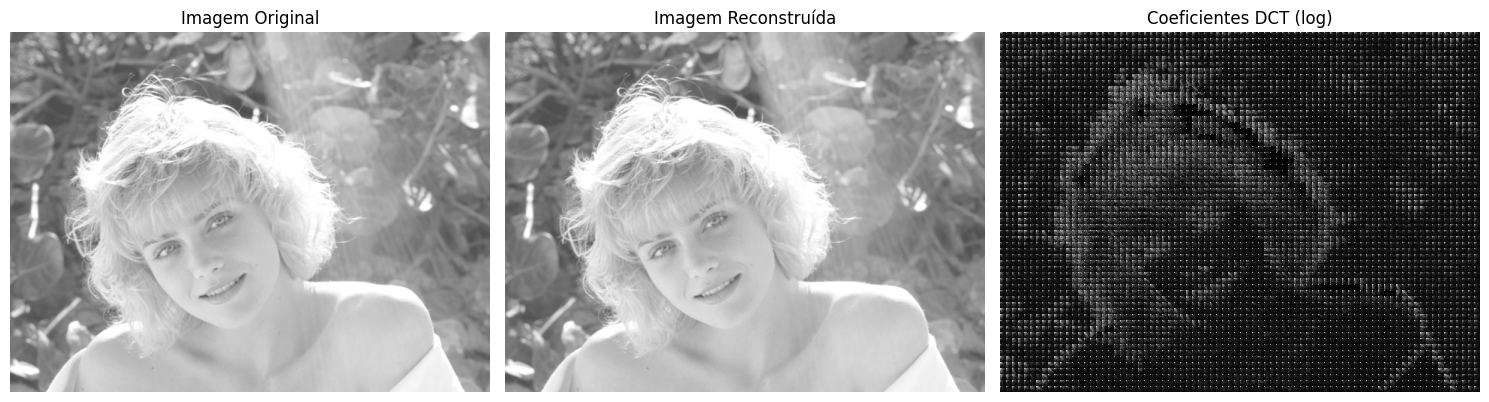

In [101]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Realiza Transformada
DCT = dct_transform(img, step)

# Realiza a Transformada Inversa
IDCT = idct_transform(DCT, step)

# Desfaz o deslocamento de 128 da imagem
img = img + 128  

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(IDCT, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

# Coeficientes DCT
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(DCT) + 1), cmap='gray')
plt.title('Coeficientes DCT (log)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [102]:
# Métricas de Erro
rmse = rmse_metric(img, IDCT)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDCT)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 1.9735972688114828e-14
Métrica PSNR: 322.12845571680845 dB


## Fourier

In [103]:
def dft_transform(img, step=8):

    size = img.shape
    DFT_REAL = np.zeros(size, dtype=float)    # Matriz para armazenar coeficientes reais da DFT
    DFT_IM = np.zeros(size, dtype=float)      # Matriz para armazenar coeficientes imaginarios da DFT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            # Aplica DFT 2D no bloco 8x8
            dft = cv2.dft(np.float32(img[y:y+step, x:x+step]), flags=cv2.DFT_COMPLEX_OUTPUT)

            DFT_REAL[y:y+step, x:x+step] = dft[:, :, 0]  # Salva o bloco DFT Real
            DFT_IM[y:y+step, x:x+step] = dft[:, :, 1]    # Salva o bloco DFT Imaginario

    # Magnitude da DFT
    dft_magnitude = cv2.magnitude(DFT_REAL, DFT_IM)

    return DFT_REAL, DFT_IM, dft_magnitude

def idft_transform(dft_coefs_real, dft_coefs_im, step=8):

    size = dft_coefs_real.shape
    IDFT_REAL = np.zeros(size, dtype=float)   # Matriz para armazenar coeficientes reais da IDFT
    IDFT_IM = np.zeros(size, dtype=float)     # Matriz para armazenar coeficientes imaginarios da IDFT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8

            dft = cv2.merge([dft_coefs_real[y:y+step, x:x+step], dft_coefs_im[y:y+step, x:x+step]])    # Junta os coefs reais e imaginários
            idft = cv2.idft(dft)                               # Aplica IDFT no bloco transformado

            IDFT_REAL[y:y+step, x:x+step] = idft[:, :, 0]     # Salva o bloco IDFT Real
            IDFT_IM[y:y+step, x:x+step] = idft[:, :, 1]     # Salva o bloco Imaginario
    
    # Magnitude da IDFT
    idft_magnitude = cv2.magnitude(IDFT_REAL, IDFT_IM)
    
    # Desfaz o deslocamento de 128
    idft_magnitude = idft_magnitude + 128

    return IDFT_REAL, IDFT_IM, idft_magnitude

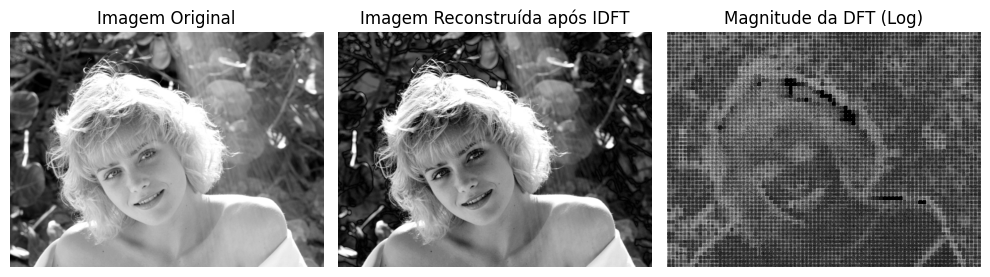

In [104]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Realiza a transformada DFT
DFT_REAL, DFT_IM, dft_magnitude = dft_transform(img, step)
log_magnitude = np.log(dft_magnitude + 1) # Aplicando log para melhorar a visualização

# Realiza a transformada inversa IDFT
IDFT_REAL, IDFT_IM, idft_magnitude = idft_transform(DFT_REAL, DFT_IM, step)

# Desfaz o deslocamento de 128
img = img + 128

# Visualizar a imagem original e a reconstruída após a IDFT
plt.figure(figsize=(10, 7))

# Imagem original
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

# Magnitude da DFT
plt.subplot(1, 3, 3)
plt.imshow(log_magnitude, cmap='gray')
plt.title('Magnitude da DFT (Log)')
plt.axis('off')

# Imagem reconstruída após a IDFT
plt.subplot(1, 3, 2)
plt.imshow(idft_magnitude, cmap='gray')
plt.title('Imagem Reconstruída após IDFT')
plt.axis('off')

plt.tight_layout()
plt.show()

In [105]:
# Métricas de Erro
rmse = rmse_metric(img, idft_magnitude)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, idft_magnitude)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 3888.5839522598685
Métrica PSNR: -23.665025982460058 dB


## Quantização

In [106]:
def quantizacao_DCT(DCT, QM, step=8):
    
    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = DCT.shape
    quant_coefs = np.zeros(size, dtype=float) # Matriz para armazenar os coeficientes quantizados
    dc_array = []                             # Array para armazenar os coeficientes DC originais
    
    for y in range(0,size[0],step):
        for x in range(0,size[1],step):

            dct = DCT[y:y+step, x:x+step]

            DC = dct[0,0]            # Adquire o coeficiente DC
            dct = np.divide(dct, QM) # Divive a DCT pela matriz de quantização
            dct = dct.round()        # Arredondamento da matriz quantizada

            quant_coefs[y:y+step, x:x+step] = dct # Salva o bloco quantizado
            dc_array.append(DC)
    
    return quant_coefs, dc_array

def desquantization_DCT(quant_coefs, dc_array, QM, useDC=True, step=8):

    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = quant_coefs.shape
    original_coefs = np.zeros(size, dtype=float)

    for y in range(0,size[0],step):
        for x in range(0,size[1],step):
            # Multiplica a matriz quantizada pela matriz de quantização
            dct = np.multiply(quant_coefs[y:y+step, x:x+step], QM)

            if (useDC == True):
                dct[0,0] = dc_array[0]  # Recupera o coeficiente DC original
                dc_array = dc_array[1:] # Retira o primeiro elemento do array
        
            original_coefs[y:y+step, x:x+step] = dct
    
    return original_coefs

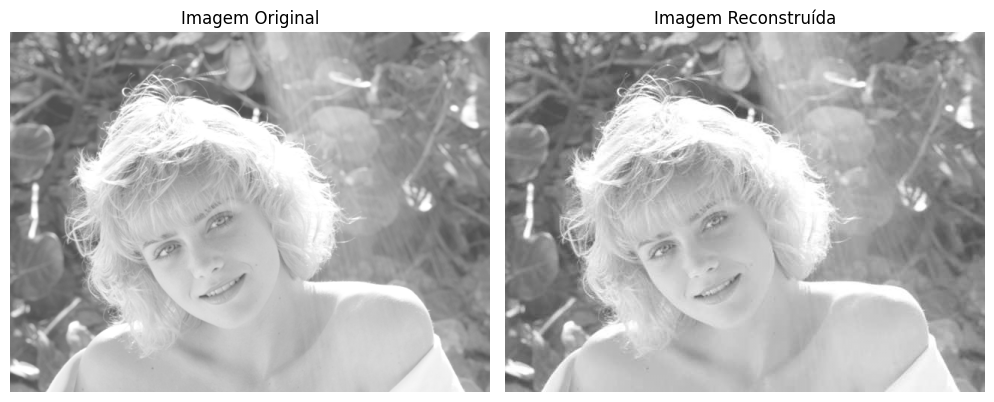

In [107]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Matriz de Quantização
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

# Realiza Transformada DCT
DCT = dct_transform(img, step)

# Quantização
quant_coefs, dc_array = quantizacao_DCT(DCT, QM)

# Desquantização
original_coefs = desquantization_DCT(quant_coefs, dc_array, QM)

# Realiza a Transformada Inversa
IDCT = idct_transform(original_coefs, step)

# Desfaz o deslocamento de 128 da imagem
img = img + 128  

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(IDCT, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

plt.tight_layout()
plt.show()

In [108]:
# Métricas de Erro
rmse = rmse_metric(img, IDCT)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDCT)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 2.728205166809998
Métrica PSNR: 39.4132630671207 dB
